# Installations and import 

In [ ]:
!pip install pennylane --upgrade

from IPython.display import clear_output
clear_output(wait=False)

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

import tensorflow as tf
from tensorflow import keras

import pandas as pd
import matplotlib.pyplot as plt

# Data

### The main dataset available on kaggle is given in a folder format for each classes. We converted that into csv file using python script which you can find in the github repo. Here we have imported that csv file and applied Quanvolutional neural network on that. 

In [ ]:
train_data = np.array(pd.read_csv('/content/train.csv'))
test_data = np.array(pd.read_csv('/content/test.csv'))

In [ ]:
train_data.shape, test_data.shape

((250, 785), (65, 785))

In [ ]:
train_len = len(train_data)
test_len = len(test_data)

In [ ]:
train_len, test_len

(250, 65)

In [ ]:
x_train = train_data[:, 0:784]
y_train = train_data[:, 784]

x_test = test_data[:, 0:784]
y_test = test_data[:, 784]

### Here the pixel values are normalized in 0 to 1 range. 

In [ ]:
x_train = x_train / 255
x_test = x_test / 255

### initially each images data is flattened to a single dimension and uploaded to the csv. So here we again reshaped the data to 28x28 format. 

In [ ]:
x_train = x_train.reshape(250,28,28)
x_test = x_test.reshape(65,28,28)

# Quanvolution

### An extra dimension is added here for the quanvolutional channels that will be created by the upcoming layers.

In [ ]:
x_train = np.array(x_train[..., tf.newaxis], requires_grad=True)
x_test = np.array(x_test[..., tf.newaxis], requires_grad=True)

In [ ]:
x_train.shape, x_test.shape

((250, 28, 28, 1), (65, 28, 28, 1))

### Total four layers of Quanvolution is implemented which is shown in the following four subsections. 

### In the later part of this discussion we will ignore the first dimension which denotes the number of images available in the dataset and discuss only (28x28x1) format of the image.

## Quanvolution Layer -1

### This first Quanvolutional layer when implemented on a (28x28x3) image data, it creates output data of (14x14x4) dimension. 

### Quantum circuit is applied on 2x2 blocks of the images and returns 4 dimensional output each time. 

In [ ]:
n_layers_quanv1 = 1

dev_1 = qml.device("default.qubit", wires=4)
# Random circuit parameters
quanv_1_params = np.random.uniform(high=2 * np.pi, size=(n_layers_quanv1, 4))

@qml.qnode(dev_1)
def circuit_1(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(quanv_1_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv_1(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit_1(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
x_train_quanv_1 = []
x_test_quanv_1 = []


print("Quanvoltional(layer-1) preprocessing of train images:")
for idx, img in enumerate(x_train):
    if((idx+1)%10==0):
        print("Train Image => {}/{}        ".format(idx + 1, train_len))
    x_train_quanv_1.append(quanv_1(img))


x_train_quanv_1 = np.array(x_train_quanv_1)



print("\nQuanvolutional(layer-1) preprocessing of test images:")
for idx, img in enumerate(x_test):
    if((idx+1)%5==0):
        print("Test Image => {}/{}        ".format(idx + 1, test_len))
    x_test_quanv_1.append(quanv_1(img))


x_test_quanv_1 = np.array(x_test_quanv_1)

Quanvoltional(layer-1) preprocessing of train images:
Train Image => 10/250        
Train Image => 20/250        
Train Image => 30/250        
Train Image => 40/250        
Train Image => 50/250        
Train Image => 60/250        
Train Image => 70/250        
Train Image => 80/250        
Train Image => 90/250        
Train Image => 100/250        
Train Image => 110/250        
Train Image => 120/250        
Train Image => 130/250        
Train Image => 140/250        
Train Image => 150/250        
Train Image => 160/250        
Train Image => 170/250        
Train Image => 180/250        
Train Image => 190/250        
Train Image => 200/250        
Train Image => 210/250        
Train Image => 220/250        
Train Image => 230/250        
Train Image => 240/250        
Train Image => 250/250        

Quanvolutional(layer-1) preprocessing of test images:
Test Image => 5/65        
Test Image => 10/65        
Test Image => 15/65        
Test Image => 20/65        
Test Image => 

### In the cell below, all the 4 channels corresponding to each main 28x28 image has been shown for four images. 

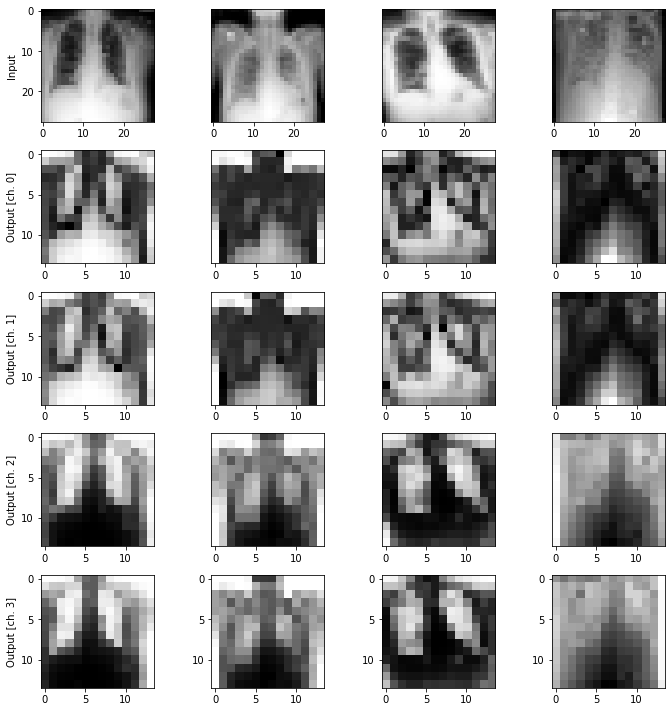

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(x_train[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(x_train_quanv_1[k, :, :, c]*256, cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
x_train_quanv_1.shape, x_test_quanv_1.shape

((250, 14, 14, 4), (65, 14, 14, 4))

### (14x14x4) dimensional data representing various aspect of each images. 

## Quanvolution Layer -2

### This second Quanvolutional layer when implemented on a (14x14x4) image data, it creates output data of (7x7x16) dimension. 

### Quantum circuit is applied on 2x2 blocks of the images and returns 4 dimensional output each time same as the previous one. 

In [ ]:
n_layers_quanv2 = 1

dev_2 = qml.device("default.qubit", wires=4)
# Random circuit parameters
quanv_2_params = np.random.uniform(high=2 * np.pi, size=(n_layers_quanv2, 4))

@qml.qnode(dev_2)
def circuit_2(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(quanv_2_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv_2(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((7, 7, 16))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 14, 2):
        for k in range(0, 14, 2):
            for l in range(4):
                # Process a squared 2x2 region of the image with a quantum circuit
                q_results = circuit_2(
                    [
                        image[j, k, l],
                        image[j, k + 1, l],
                        image[j + 1, k, l],
                        image[j + 1, k + 1, l]
                    ]
                )
                # Assign expectation values to different channels of the output pixel (j/2, k/2)
                for c in range(4):
                    out[j // 2, k // 2, (l*4)+c] = q_results[c]
    return out

In [ ]:
x_train_quanv_2 = []
x_test_quanv_2 = []


print("Quanvoltional(layer-2) preprocessing of train images:")
for idx, img in enumerate(x_train_quanv_1):
    if((idx+1)%10==0):
        print("Train Image => {}/{}        ".format(idx + 1, train_len))
    x_train_quanv_2.append(quanv_2(img))

x_train_quanv_2 = np.array(x_train_quanv_2)



print("\nQuanvolutional(layer-2) preprocessing of test images:")
for idx, img in enumerate(x_test_quanv_1):
    if((idx+1)%5==0):
        print("Test Image => {}/{}        ".format(idx + 1, test_len))
    x_test_quanv_2.append(quanv_2(img))

x_test_quanv_2 = np.array(x_test_quanv_2)

Quanvoltional(layer-2) preprocessing of train images:
Train Image => 10/250        
Train Image => 20/250        
Train Image => 30/250        
Train Image => 40/250        
Train Image => 50/250        
Train Image => 60/250        
Train Image => 70/250        
Train Image => 80/250        
Train Image => 90/250        
Train Image => 100/250        
Train Image => 110/250        
Train Image => 120/250        
Train Image => 130/250        
Train Image => 140/250        
Train Image => 150/250        
Train Image => 160/250        
Train Image => 170/250        
Train Image => 180/250        
Train Image => 190/250        
Train Image => 200/250        
Train Image => 210/250        
Train Image => 220/250        
Train Image => 230/250        
Train Image => 240/250        
Train Image => 250/250        

Quanvolutional(layer-2) preprocessing of test images:
Test Image => 5/65        
Test Image => 10/65        
Test Image => 15/65        
Test Image => 20/65        
Test Image => 

### In the cell below, all the 16 channels corresponding to each main 28x28 image has been shown for four images. 

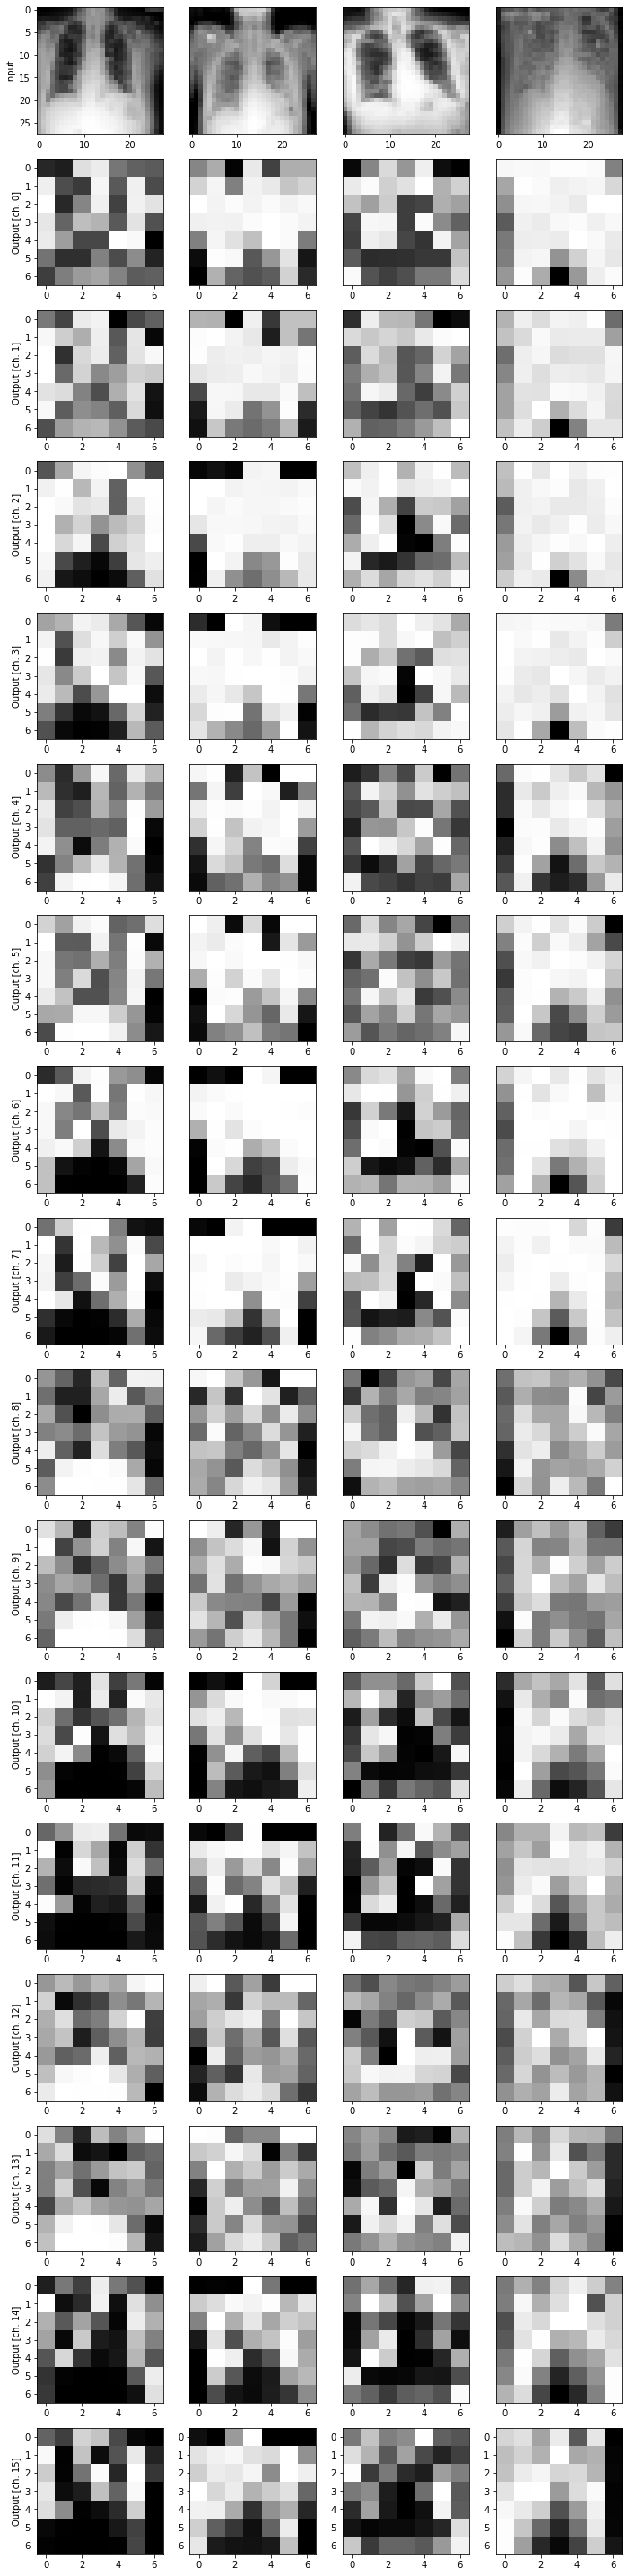

In [ ]:
n_samples = 4
n_channels = 16
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 40))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(x_train[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(x_train_quanv_2[k, :, :, c]*256, cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
x_train_quanv_2.shape, x_test_quanv_2.shape

((250, 7, 7, 16), (65, 7, 7, 16))

### (7x7x16) dimensional data representing various aspect of each images. 

## Quanvolution Layer -3

### This first Quanvolutional layer when implemented on a (7x7x16) image data, it creates output data of (3x3x64) dimension. 

### Quantum circuit is applied on 3x3 blocks of the images and returns 4 dimensional output each time, the block selection here is little different from first and second layer circuit. 

In [ ]:
n_layers_quanv3 = 1

dev_3 = qml.device("default.qubit", wires=4)
# Random circuit parameters
quanv_3_params = np.random.uniform(high=2 * np.pi, size=(n_layers_quanv3, 4))

@qml.qnode(dev_3)
def circuit_3(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(quanv_3_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv_3(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((3, 3, 64))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 6, 2):
        for k in range(0, 6, 2):
            for l in range(16):
                # Process a squared 2x2 region of the image with a quantum circuit
                q_results = circuit_3(
                    [
                        image[j, k, l]*image[j+1, k+1, l],
                        image[j, k + 2, l]*image[j+1, k+1, l],
                        image[j + 2, k, l]*image[j+1, k+1, l],
                        image[j + 2, k + 2, l]*image[j+1, k+1, l]
                    ]
                )
                # Assign expectation values to different channels of the output pixel (j/2, k/2)
                for c in range(4):
                    out[(j+2) // 3, (k+2) // 3, (l*4)+c] = q_results[c]
    return out

In [ ]:
x_train_quanv_3 = []
x_test_quanv_3 = []


print("Quanvoltional(layer-3) preprocessing of train images:")
for idx, img in enumerate(x_train_quanv_2):
    if((idx+1)%10==0):
        print("Train Image => {}/{}        ".format(idx + 1, train_len))
    x_train_quanv_3.append(quanv_3(img))

x_train_quanv_3 = np.array(x_train_quanv_3)



print("\nQuanvolutional(layer-3) preprocessing of test images:")
for idx, img in enumerate(x_test_quanv_2):
    if((idx+1)%5==0):
        print("Test Image => {}/{}        ".format(idx + 1, test_len))
    x_test_quanv_3.append(quanv_3(img))

x_test_quanv_3 = np.array(x_test_quanv_3)

Quanvoltional(layer-3) preprocessing of train images:
Train Image => 10/250        
Train Image => 20/250        
Train Image => 30/250        
Train Image => 40/250        
Train Image => 50/250        
Train Image => 60/250        
Train Image => 70/250        
Train Image => 80/250        
Train Image => 90/250        
Train Image => 100/250        
Train Image => 110/250        
Train Image => 120/250        
Train Image => 130/250        
Train Image => 140/250        
Train Image => 150/250        
Train Image => 160/250        
Train Image => 170/250        
Train Image => 180/250        
Train Image => 190/250        
Train Image => 200/250        
Train Image => 210/250        
Train Image => 220/250        
Train Image => 230/250        
Train Image => 240/250        
Train Image => 250/250        

Quanvolutional(layer-3) preprocessing of test images:
Test Image => 5/65        
Test Image => 10/65        
Test Image => 15/65        
Test Image => 20/65        
Test Image => 

### In the cell below, the first 20 channels (among all 64 channels) corresponding to each main 28x28 image has been shown for four images. 

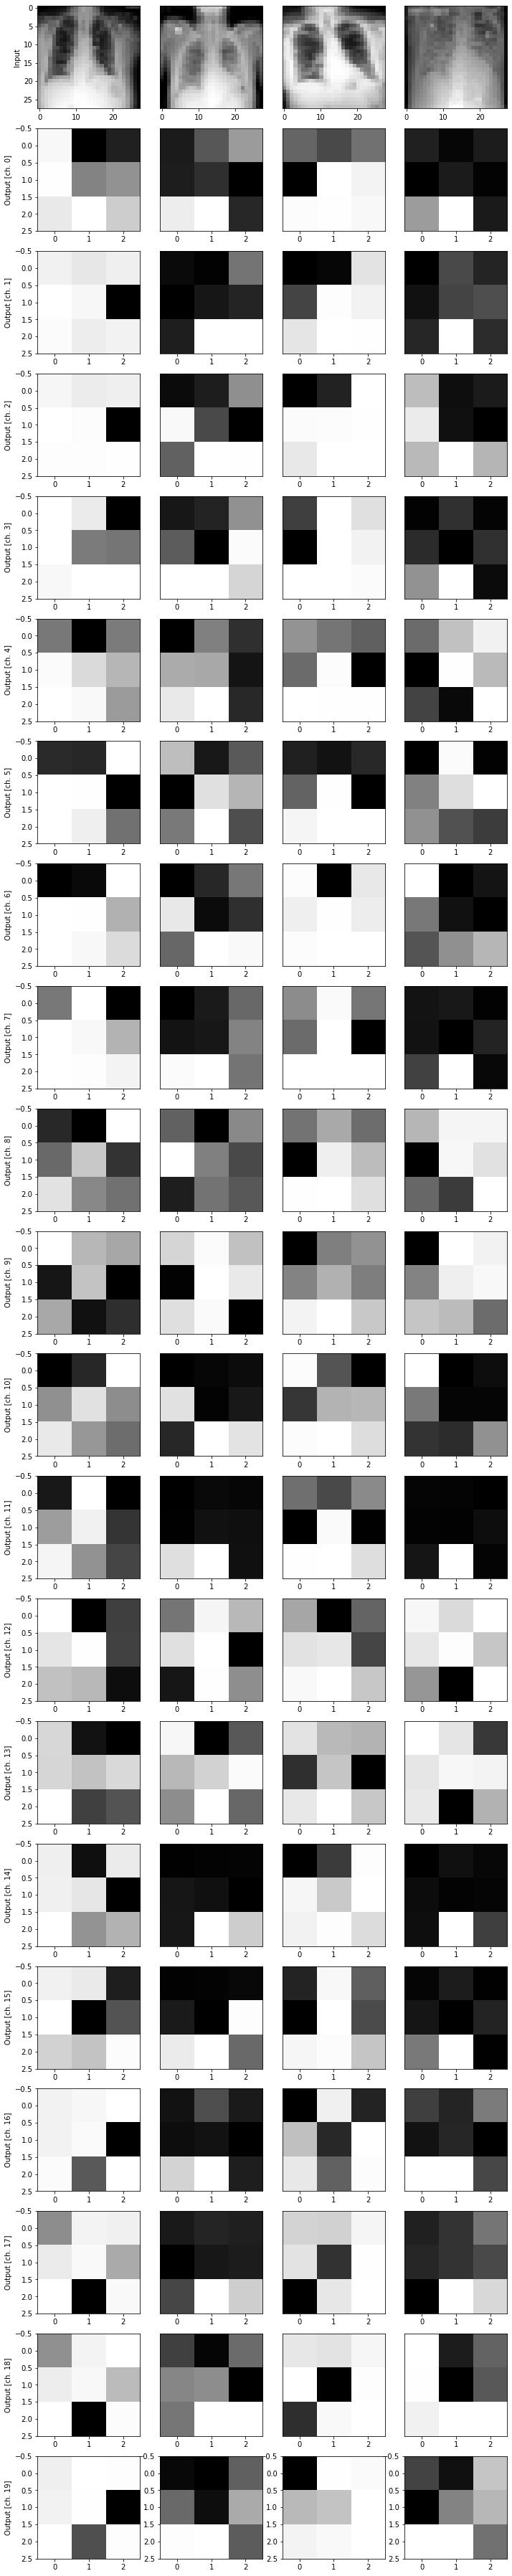

In [ ]:
n_samples = 4
n_channels = 20
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 50))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(x_train[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(x_train_quanv_3[k, :, :, c]*256, cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
x_train_quanv_3.shape, x_test_quanv_3.shape

((250, 3, 3, 64), (65, 3, 3, 64))

### (3x3x64) dimensional data representing various aspect of each images. 

## Quanvolution Layer -4

### This first Quanvolutional layer when implemented on a (3x3x64) image data, it creates output data of (1x1x256) dimension. 

### Quantum circuit is applied on 3x3 blocks of the images and returns 4 dimensional output each time, the block selection here is little different from first or second layer circuit and similar to the third layer circuit. 

In [ ]:
n_layers_quanv4 = 1

dev_4 = qml.device("default.qubit", wires=4)
# Random circuit parameters
quanv_4_params = np.random.uniform(high=2 * np.pi, size=(n_layers_quanv4, 4))

@qml.qnode(dev_4)
def circuit_4(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(quanv_4_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv_4(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((1, 1, 256))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0,2,2):
        for k in range(0,2,2):
            for l in range(64):
                # Process a squared 2x2 region of the image with a quantum circuit
                q_results = circuit_4(
                    [
                        image[j, k, l]*image[j+1, k+1, l],
                        image[j, k + 2, l]*image[j+1, k+1, l],
                        image[j + 2, k, l]*image[j+1, k+1, l],
                        image[j + 2, k + 2, l]*image[j+1, k+1, l]
                    ]
                )
                # Assign expectation values to different channels of the output pixel (j/2, k/2)
                for c in range(4):
                    out[(j+2) // 3, (k+2) // 3, (l*4)+c] = q_results[c]
    return out

In [ ]:
x_train_quanv_4 = []
x_test_quanv_4 = []


print("Quanvoltional(layer-4) preprocessing of train images:")
for idx, img in enumerate(x_train_quanv_3):
    if((idx+1)%10==0):
        print("Train Image => {}/{}        ".format(idx + 1, train_len))
    x_train_quanv_4.append(quanv_4(img))

x_train_quanv_4 = np.array(x_train_quanv_4)



print("\nQuanvolutional(layer-4) preprocessing of test images:")
for idx, img in enumerate(x_test_quanv_3):
    if((idx+1)%5==0):
        print("Test Image => {}/{}        ".format(idx + 1, test_len))
    x_test_quanv_4.append(quanv_4(img))

x_test_quanv_4 = np.array(x_test_quanv_4)

Quanvoltional(layer-4) preprocessing of train images:
Train Image => 10/250        
Train Image => 20/250        
Train Image => 30/250        
Train Image => 40/250        
Train Image => 50/250        
Train Image => 60/250        
Train Image => 70/250        
Train Image => 80/250        
Train Image => 90/250        
Train Image => 100/250        
Train Image => 110/250        
Train Image => 120/250        
Train Image => 130/250        
Train Image => 140/250        
Train Image => 150/250        
Train Image => 160/250        
Train Image => 170/250        
Train Image => 180/250        
Train Image => 190/250        
Train Image => 200/250        
Train Image => 210/250        
Train Image => 220/250        
Train Image => 230/250        
Train Image => 240/250        
Train Image => 250/250        

Quanvolutional(layer-4) preprocessing of test images:
Test Image => 5/65        
Test Image => 10/65        
Test Image => 15/65        
Test Image => 20/65        
Test Image => 

### finally 256 channels from each image data has been created at the end of 4th quanvolutional layer. But it is not feasible to show all 256 channels here. 

In [ ]:
# n_samples = 4
# n_channels = 20
# fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 50))
# for k in range(n_samples):
#     axes[0, 0].set_ylabel("Input")
#     if k != 0:
#         axes[0, k].yaxis.set_visible(False)
#     axes[0, k].imshow(x_train[k, :, :, 0], cmap="gray")

#     # Plot all output channels
#     for c in range(n_channels):
#         axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
#         if k != 0:
#             axes[c, k].yaxis.set_visible(False)
#         axes[c + 1, k].imshow(x_train_quanv_4[k, :, :, c]*256, cmap="gray")

# plt.tight_layout()
# plt.show()

In [ ]:
x_train_quanv_4.shape, x_test_quanv_4.shape

((250, 1, 1, 256), (65, 1, 1, 256))

### (1x1x256) dimensional data representing various aspect of each images. 

# Flattening the data and Saving it on npy format

### Finally the (1x1x256) dimensional data representing each images has been flattened to a single dimension of 256. 

In [ ]:
x_train_final = x_train_quanv_4.reshape(250, 256)
x_test_final = x_test_quanv_4.reshape(65, 256)

In [ ]:
x_train_final.shape, x_test_final.shape

((250, 256), (65, 256))

In [ ]:
np.save("x_train_final.npy", x_train_final)
np.save("y_train.npy", y_train)

np.save("x_test_final.npy", x_test_final)
np.save("y_test.npy", y_test)

### The data is saved in four .npy format files for accessing later for the classifier model nnotebooks. 